In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 设置字体大小
plt.rcParams['font.size'] = 20


In [5]:
data_path = r'..\Question\Wimbledon_featured_matches.csv'
data = pd.read_csv(data_path)
print(data.head())

              match_id         player1        player2 elapsed_time  set_no  \
0  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:00:00       1   
1  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:00:38       1   
2  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:01:01       1   
3  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:01:31       1   
4  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:02:21       1   

   game_no  point_no  p1_sets  p2_sets  p1_games  ...  p2_break_pt_won  \
0        1         1        0        0         0  ...                0   
1        1         2        0        0         0  ...                0   
2        1         3        0        0         0  ...                0   
3        1         4        0        0         0  ...                0   
4        1         5        0        0         0  ...                0   

  p1_break_pt_missed p2_break_pt_missed  p1_distance_run  p2_distance_run  \
0        

In [6]:
# 按match_id分组
grouped = data.groupby('match_id')
print(grouped.size())

match_id
2023-wimbledon-1301    300
2023-wimbledon-1302    201
2023-wimbledon-1303    134
2023-wimbledon-1304    337
2023-wimbledon-1305    246
2023-wimbledon-1306    332
2023-wimbledon-1307    232
2023-wimbledon-1308    190
2023-wimbledon-1309    213
2023-wimbledon-1310    318
2023-wimbledon-1311    170
2023-wimbledon-1312    275
2023-wimbledon-1313    290
2023-wimbledon-1314    185
2023-wimbledon-1315    198
2023-wimbledon-1316    167
2023-wimbledon-1401    225
2023-wimbledon-1402    274
2023-wimbledon-1403    122
2023-wimbledon-1404    286
2023-wimbledon-1405    215
2023-wimbledon-1406    195
2023-wimbledon-1407    331
2023-wimbledon-1408    271
2023-wimbledon-1501    189
2023-wimbledon-1502    283
2023-wimbledon-1503    193
2023-wimbledon-1504    217
2023-wimbledon-1601    159
2023-wimbledon-1602    202
2023-wimbledon-1701    334
dtype: int64


In [19]:
def analyse_all_match(all_match):
    # 统计所有球员的姓名
    player1 = all_match['player1']
    player2 = all_match['player2']
    player = pd.concat([player1, player2], axis=0)
    # 取唯一值
    player = player.unique()
    # 字典序
    player.sort()
    player2index = {name: i for i, name in enumerate(player)}
    # 构建胜负矩阵
    win_matrix = np.zeros((len(player), len(player)))
    lose_matrix = np.zeros((len(player), len(player)))
    # 遍历每场比赛
    for match_id, match in all_match.groupby('match_id'):
        # 获取比赛结果
        player1 = match['player1'].values[0]
        player2 = match['player2'].values[0]
        win_index = match['point_victor'].values[0]
        winner_index = player2index[player1] if win_index == 1 else player2index[player2]
        loser_index = player2index[player1] if win_index == 2 else player2index[player2]
        # 更新胜负矩阵
        win_matrix[winner_index, loser_index] += 1
        lose_matrix[loser_index, winner_index] += 1
    return win_matrix, lose_matrix, player
win_matrix, lose_matrix, player = analyse_all_match(data)

C:\Users\cheng\AppData\Local\Temp\ipykernel_142688\3225885265.py:6: RuntimeWarning: divide by zero encountered in log
  likelihood += win_matrix[i, j] * np.log(gamma[i] / (gamma[i] + gamma[j]))
C:\Users\cheng\AppData\Local\Temp\ipykernel_142688\3225885265.py:6: RuntimeWarning: invalid value encountered in scalar multiply
  likelihood += win_matrix[i, j] * np.log(gamma[i] / (gamma[i] + gamma[j]))
C:\Users\cheng\AppData\Local\Temp\ipykernel_142688\3225885265.py:6: RuntimeWarning: invalid value encountered in scalar divide
  likelihood += win_matrix[i, j] * np.log(gamma[i] / (gamma[i] + gamma[j]))
C:\Users\cheng\AppData\Local\Temp\ipykernel_142688\3225885265.py:23: RuntimeWarning: invalid value encountered in divide
  sum_ = np.sum(N / gamma_sum)


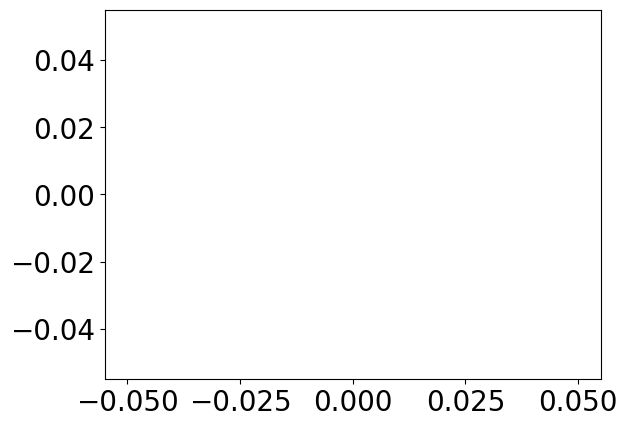

In [25]:
def cal_likelihood(gamma, win_matrix, lose_matrix):
    likelihood = 0
    for i in range(len(player)):
        for j in range(len(player)):
            if i != j:
                likelihood += win_matrix[i, j] * np.log(gamma[i] / (gamma[i] + gamma[j]))
    return likelihood

def Bradley_Terry(win_matrix, lose_matrix, player):
    # 初始化参数
    gamma = np.ones(len(player))
    # 迭代次数
    max_iter = 100
    likelihood_list = []
    # 迭代
    for _ in range(max_iter):
        # 更新参数
        gamma_copy = gamma.copy()
        for i in range(len(player)):
            W = np.sum(win_matrix[i, :])
            N = win_matrix[i, :] + lose_matrix[i, :]
            gamma_sum = gamma[i] + gamma
            sum_ = np.sum(N / gamma_sum)
            gamma_copy[i] = W / sum_
        gamma = gamma_copy
        # 计算似然函数值
        likelihood = cal_likelihood(gamma, win_matrix, lose_matrix)
        likelihood_list.append(likelihood)
    return gamma, likelihood_list

gamma, likelihood_list = Bradley_Terry(win_matrix, lose_matrix, player)
plt.plot(likelihood_list)